## Penalty Term for Degree Dist

Trying to implement part of the 'recipie' for evaluating power law distribution fits. Reference [1] from my weekly notes (2019-08-13).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
from scipy.special  import zeta

from scipy.stats import zipf

Need to generate some input data. Need examples for both 'good' and 'bad' degree distributions. The goal is to have 'histograms' for each. These will be the input for the KSS calculations. 

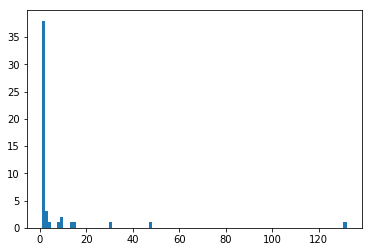

In [3]:
N = 50

# 'Power law' Distribution - zipf
a = 2.0
random_data_z = zipf.rvs(a, size=N)
plt.hist(random_data_z, 100)
plt.show()


Looks like this is working! Fun fact, the parameter needs to be in the same ranges we'd expect the power law parameter to be for 'interesting' distributions to show up. so something larger (NOT equal to) 1, and also less than or equal to 2.0? Maybe more? I'm forgetting my social network theory stuff. 

For the random dist, I'll just pick some arbitrary values. Maybe make the max the largest value from the zipf dist?

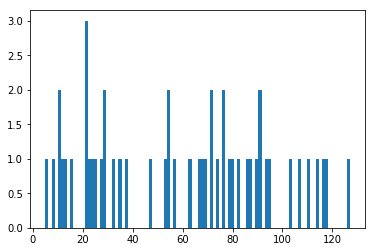

In [4]:
# Random Distribution
min_x = 1
max_x = random_data_z.max()

random_data_r = np.random.randint(min_x, max_x, size=N)

plt.hist(random_data_r, 100)
plt.show()

Cool! Now to build the functions that are to be optimized. 

In [5]:
def mle_beta_samples(samples):
    lng = 0
    hist_cnts, hist_bins = np.histogram(samples)
    for i in range(len(hist_cnts)):
        if(hist_cnts[i] > 0): # Or stuff gets fucky real quick.
            lng += np.log(hist_cnts[i])
    
    Na = hist_cnts[0] # The zero-th element is our ath bin, which is always 1 for our purposes.
    lng = (1.0/Na)*lng

    def mle_beta(x):
        return -1.0*zeta(x+1, 1.0)-(x+1)*lng
    
    return mle_beta   

In [6]:
beta_loss = mle_beta_samples(random_data_z)

In [7]:
result = minimize(beta_loss, 1.0, method='Nelder-Mead')
print(result)

 final_simplex: (array([[5.32907052e-16],
       [1.24344979e-15]]), array([-2.25179981e+15, -7.50599938e+14]))
           fun: -2251799813685248.5
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 200
           nit: 100
        status: 1
       success: False
             x: array([5.32907052e-16])


Well thats not great. Lets look at the graph we think we are optimizing.

In [8]:
x_s = np.arange(1.0, 5.0, 0.01)
y_s = beta_loss(x_s)

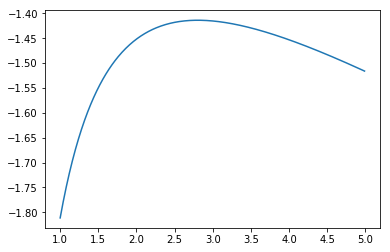

In [9]:
plt.plot(x_s, y_s)
plt.show()

Well look at that, it actually DOES have a maximum. Turns out I cant read, and tried to optimize with a minimize on a function with no minimum. What happens if we negate our function so it actually has a minimum?

In [10]:
def new_beta(x):
    return -1.0*beta_loss(x)

result = minimize(new_beta, 0.1, method='Nelder-Mead')
print(result)

 final_simplex: (array([[2.80351563],
       [2.80359375]]), array([1.41378914, 1.41378914]))
           fun: 1.4137891395157176
       message: 'Optimization terminated successfully.'
          nfev: 46
           nit: 23
        status: 0
       success: True
             x: array([2.80351563])


HAHAHAHAHA YESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS!!!! Looks like it finds one NEAR 2. Which is AWESOME.
Now just need to do this for the next step, the KSS calculation/optimzation. 

First, instead of forming this in such a way that I can shove it into a minimization, lets just look at all the possible values for all of our bins. That is, we want to just plot the values of d_emp for all the bins we have, up to the last bin.

In [1]:
def d_emp(n, Na, Nn, beta):    
    def S(x, b):
        return zeta(x+1, n)/zeta(x+1, 1)
    return np.abs((Nn/Na)-S(n, beta))

In [33]:
def manual_demp_plot(samples, beta_emp):
    # To make life easy, setting the number of bins to equal the largest value, lots of empty
    # entries, but means I can use the index into the counts as n. That is, n = index+1 while
    # looping over the counts.
    hist_cnts, hist_bins = np.histogram(samples, bins=(samples.max()+1))
    Na  = hist_cnts[0]
    y_s = []
    for i in range(1, len(hist_cnts)):
        n  = i+1
        Nn = hist_cnts[i]
        y_s.append(d_emp(n, Na, Nn, beta_emp))

    plt.plot(range(1, len(hist_cnts)), y_s)
    plt.show()
    return y_s

Power Law Random Data


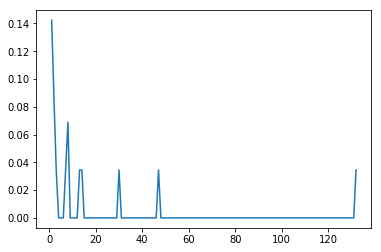

max demp:  0.14225220016691434


In [38]:
print("Power Law Random Data")
y_pl = manual_demp_plot(random_data_z, result['x'])
print("max demp: ", max(y_pl))

So thats for the 'pure' power law dist. Looks like the max is at the start, and its small, like 0.14.

Now to run this same thing for the 'bad' dist and hope we get huge values.

Uniform Random Data


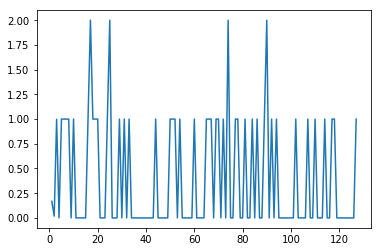

max demp:  2.0


In [39]:
print("Uniform Random Data")
y_u = manual_demp_plot(random_data_r, result['x'])
print("max demp: ", max(y_u))

Ok! Looks like this one has larger spikes. Much larger, values higher than one. Should try this out on a lot more different distributions with lots of different parameters. But this seems like a good candidate for the start of a (expensive) penalty term.

Next step is to see if I can do the above with something like the minimize function. I don't think I can? But the previous calculation looks like it could maybe be turned into a tensor operation. That is, we could do a 'single' operation to yield the d_emps for all bins, then take the max of that for the penalty term. 

If the cost for yielding the adjacency matrix are somehow kept low, and the cost for the empirical beta calculation can be kept low, then this step should be the easiest. The next step would be to see if adding this into an actual training flow can be accomplished. Need to figure out how to track the complexity in a 'real' metric, like wall clock, sample complexity, epoch count. Idk, one of those probably makes the most sense. 